### ML Lab Final Project

Jesse Moore<br>
Kyrill Rekun<br>
Haree Srinivasan

In [112]:
import numpy as np
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from rfpimp import *
import boto3

import warnings
warnings.filterwarnings('ignore')

### Data:

Pitches and Atbats: https://www.kaggle.com/pschale/mlb-pitch-data-20152018

In [113]:
client = boto3.client('s3') #low-level functional API

In [114]:
obj = client.get_object(Bucket='ml-lab-project',Key='atbats.csv')
atbats = pd.read_csv(obj['Body'])
atbats.head()

,ab_id,batter_id,event,g_id,inning,o,p_score,p_throws,pitcher_id,stand,top
0,2015000001,572761,Groundout,201500001,1,1,0,L,452657,L,True
1,2015000002,518792,Double,201500001,1,1,0,L,452657,L,True
2,2015000003,407812,Single,201500001,1,1,0,L,452657,R,True
3,2015000004,425509,Strikeout,201500001,1,2,0,L,452657,R,True
4,2015000005,571431,Strikeout,201500001,1,3,0,L,452657,L,True


In [115]:
obj = client.get_object(Bucket='ml-lab-project',Key='pitches.csv')
pitches = pd.read_csv(obj['Body'])
pitches.head()

,px,pz,start_speed,end_speed,spin_rate,spin_dir,break_angle,break_length,break_y,ax,...,event_num,b_score,ab_id,b_count,s_count,outs,pitch_num,on_1b,on_2b,on_3b
0,0.416,2.963,92.9,84.1,2305.052,159.235,-25.0,3.2,23.7,7.665,...,3,0.0,2.015000e+09,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,-0.191,2.347,92.8,84.1,2689.935,151.402,-40.7,3.4,23.7,12.043,...,4,0.0,2.015000e+09,0.0,1.0,0.0,2.0,0.0,0.0,0.0
2,-0.518,3.284,94.1,85.2,2647.972,145.125,-43.7,3.7,23.7,14.368,...,5,0.0,2.015000e+09,0.0,2.0,0.0,3.0,0.0,0.0,0.0
3,-0.641,1.221,91.0,84.0,1289.590,169.751,-1.3,5.0,23.8,2.104,...,6,0.0,2.015000e+09,0.0,2.0,0.0,4.0,0.0,0.0,0.0
4,-1.821,2.083,75.4,69.6,1374.569,280.671,18.4,12.0,23.8,-10.280,...,7,0.0,2.015000e+09,1.0,2.0,0.0,5.0,0.0,0.0,0.0


### Functions for creating a list of pipelines. 
#### Note that for the sake of reproducibility KNN and SVM are commented out because they take a looooong time to complete on our big dataset

In [39]:
def make_pipelines():
    """Create a pipeline for each of the following algorithms:
    1. Logistic Regression
    2. k-nearest neighbors (KNN) 
    3. Naive Bayes (Guassian)
    4. Support Vector Machines (SVM)
    5. Random Forest™ 
    
    If appropriate, apply StandardScaler before the algorithm.   
    Use default hyperparameters.
    If an algorithm takes random_state then random_state=42 
    
    Return a list of all the pipelines.
    """ 
    pipelines = []
    state = 42
    
    pipelines.append(Pipeline([('sc', StandardScaler()),
                               ('LogisticRegression', LogisticRegression(random_state=state,multi_class='auto'))]))
    # pipelines.append(Pipeline([('sc', StandardScaler()),('KNeighborsClassifier', KNeighborsClassifier())]))
    
    # Technically Standard Scaling is not needed for GaussianNB!
    pipelines.append(Pipeline([('sc', StandardScaler()),('GaussianNB', GaussianNB())]))
    # pipelines.append(Pipeline([('sc', StandardScaler()),('SVC', SVC(random_state=state))]))
    pipelines.append(Pipeline([('sc', StandardScaler()),
                               ('RandomForestClassifier', RandomForestClassifier(random_state=state))]))
    
    return pipelines

### Functions for sorting pipelines by best performance

In [4]:
def sort_models(pipelines, X_data, y_data, metric=f1_score, average='weighted'):
    scores = dict()
    for pipe in pipelines:
        scores[pipe.steps[1][0]] = f1_score(y_data, pipe.predict(X_data),average=average)
    scores_sorted = dict(sorted(scores.items(), key = lambda x: x[1], reverse=True))
    return scores_sorted

# Classifying Pitch Type based on velocity/trajectory data

Choose the 4 msot common pitches: Fastball, Changeup, Slider, Curve <br>
These 4 pitches are selected because they have different pitch trajectories or different speeds. As we have seen in class too many similar categories makes the model perform much worse.

### Data Preprocessing:

In [105]:
# Filter for only the 4 most common pitches we are interested in.
clean_pitch = pitches.loc[(pitches.pitch_type == 'CH') | (pitches.pitch_type == 'CU') | 
                         (pitches.pitch_type == 'FF') | (pitches.pitch_type == 'SL'),] 

# Convert Target into numeric categories 
clean_pitch['pitch_type'] = clean_pitch['pitch_type'].astype('category')
clean_pitch['pitch_type_cat'] = clean_pitch['pitch_type'].cat.codes

# Take only the features we want to use
clean_pitch_df = clean_pitch[['pitch_type_cat','start_speed','end_speed','spin_rate','spin_dir',
                          'break_angle','break_length','break_y' ]]


clean_pitch_df.head()

,pitch_type_cat,start_speed,end_speed,spin_rate,spin_dir,break_angle,break_length,break_y
0,2,92.9,84.1,2305.052,159.235,-25.0,3.2,23.7
1,2,92.8,84.1,2689.935,151.402,-40.7,3.4,23.7
2,2,94.1,85.2,2647.972,145.125,-43.7,3.7,23.7
3,2,91.0,84.0,1289.590,169.751,-1.3,5.0,23.8
4,1,75.4,69.6,1374.569,280.671,18.4,12.0,23.8


In [95]:
y = clean_pitch_df['pitch_type_cat']
X = clean_pitch_df.drop(['pitch_type_cat'],axis=1)

# Split into training and test
X_train, X_test,y_train, y_test = train_test_split(X, y, test_size = .2, random_state=42)

In [40]:
# Make pipelines
pipelines = make_pipelines()

In [41]:
# Fit each pipeline
for pipe in pipelines:
    pipe.fit(X_train, y_train)

In [42]:
# Print out confusion matrix for each pipeline to see how we did on the training set
for pipe in pipelines:
    print('Model:', pipe.steps[1][0], '\n',classification_report(y_train, pipe.predict(X_train)),'\n')

Model: LogisticRegression 
               precision    recall  f1-score   support

           0       0.85      0.70      0.77    234254
           1       0.83      0.76      0.79    187433
           2       0.95      0.98      0.97    811780
           3       0.77      0.85      0.81    360641

    accuracy                           0.88   1594108
   macro avg       0.85      0.82      0.83   1594108
weighted avg       0.88      0.88      0.88   1594108
 

Model: GaussianNB 
               precision    recall  f1-score   support

           0       0.82      0.80      0.81    234254
           1       0.76      0.81      0.79    187433
           2       0.97      0.97      0.97    811780
           3       0.81      0.82      0.81    360641

    accuracy                           0.89   1594108
   macro avg       0.84      0.85      0.85   1594108
weighted avg       0.89      0.89      0.89   1594108
 

Model: RandomForestClassifier 
               precision    recall  f1-score   

#### To no surpise the best performing model was RandomForest.

In [51]:
# RandomForest Parameter Tuning, but again it takes forever to finish running 
rf = RandomForestClassifier(random_state=42)
hyperparameters = {"max_depth": [3, 4, None], 
                   "min_samples_leaf": [10, 15],
                   "max_features": [3, 4, 5, None],
                   }

clf = RandomizedSearchCV(rf, hyperparameters, cv=5, n_iter=5,n_jobs=-1)
search = clf.fit(X_train,y_train)
search.best_params_

In [96]:
pipe_rf = pipelines[2]
pipe_rf.fit(X_train,y_train)

Pipeline(memory=None,
         steps=[('RandomForest',
                 RandomForestClassifier(bootstrap=True, class_weight=None,
                                        criterion='gini', max_depth=None,
                                        max_features='auto',
                                        max_leaf_nodes=None,
                                        min_impurity_decrease=0.0,
                                        min_impurity_split=None,
                                        min_samples_leaf=1, min_samples_split=2,
                                        min_weight_fraction_leaf=0.0,
                                        n_estimators=10, n_jobs=None,
                                        oob_score=False, random_state=None,
                                        verbose=0, warm_start=False))],
         verbose=False)

In [63]:
# RandomForest Cross Validation
cross_val_score(estimator=pipe_rf, X=X_train, y=y_train, cv=5, scoring='f1_weighted',n_jobs=-1)

array([0.92088673, 0.91980304, 0.91985363, 0.92033856, 0.9204207 ])

__Feature Importance:__

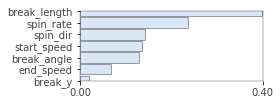

In [106]:
imp = importances(pipe_rf, X_train, y_train)
viz = plot_importances(imp)
viz.view()

__Model Evaluation:__

F1_score is out "north star" metric

In [64]:
# Training score
y_train = np.array(y_train).reshape(-1, 1)
y_train_pred = pipe_rf.predict(X_train)
f1_train = f1_score(y_train, y_train_pred, average="weighted")
round(f1_train, 2)

0.99

In [68]:
# Testing score
y_test = np.array(y_test).reshape(-1, 1)
y_test_pred = pipe_rf.predict(X_test)
f1_test = f1_score(y_test, y_test_pred, average="weighted")
round(f1_test, 2)

0.92

### Classifying Baseball Pitches Sumary:

RandomForest was the clearly the best model even with minimal hyper parameter tuning. The most misclassifications occured when decided between a slower fastball vs faster slider with minimal break and curveball vs slower slider with a lot of break. Other than these border cases we think the model did very well. This falls in line with what baseball players see while hitting. They try to guess what pitch is coming based on release point and speed. When they get fooled by pitches it is often times these very same border cases. 



Predicting Fastball or Offspeed
=====
"Hard" pitches: 4-seam fastball, 2-seam fastball, cutter, sinker <br>
Offspeed: Curveball, Change-up, Slider, Knuckle Curve, Splitter, Eephus, Screwball, Knuckleball <br>
Pitches not considered: pitchouts and intentional balls

### Data Preprocessing

In [71]:
#Merging dataframes
active_df = pitches.merge(atbats, how="left", on="ab_id")

#Creating a column that determines the lead the pitcher's team has (negative means the batter's team is winning)
active_df["p_lead"] = np.abs(active_df["p_score"] - active_df["b_score"])

#eliminate counts with 4 balls (makes no sense)
active_df = active_df.loc[active_df['b_count']<4]

#get rid of rows where the target is null or unknown
active_df = active_df.loc[(active_df["pitch_type"].isna()==False) & (active_df["pitch_type"]!="UN")]

#AB is not a documented pitch type; IN, FO, and PO are intentional balls
active_df = active_df.loc[(active_df["pitch_type"]!="AB") & (active_df["pitch_type"]!="PO") & (active_df["pitch_type"]!="FO") & (pitches["pitch_type"]!="IN"),:]

# Pitches that are considered "hard", or thrown at a high velocity
hard_pitches = ["FF", "FC", "FT", "SI"]

# Lower velocity pitches
off_speed = ["CU", "CH", "SL", "KC", "EP", "FS", "KN", "SC"]

#Classifying pitches as either fast or slow
active_df["velo_type"] = [1 if pitch in hard_pitches else 0 for pitch in active_df.pitch_type]

target = active_df["velo_type"]

In [108]:
# Split into training and test
X_train, X_test, y_train, y_test = train_test_split(active_df, target, test_size=0.25)

In [109]:
convert2dummy = ["b_count", "s_count", "outs", "inning", "stand", "p_throws"]
c2d_pipe = Pipeline([("encoder", OneHotEncoder())])

# Already Dummy variables
already_dummy = ["on_1b", "on_2b", "on_3b"]
# Numerical feature
num_feat = ["p_lead"]
num_pipe = Pipeline([("scaler", StandardScaler())])

preprocessor = ColumnTransformer(transformers=[
    ("num", num_pipe, num_feat),
    ("c2d", c2d_pipe, convert2dummy),
    ("already_dummy", "passthrough", already_dummy)])

# KNN was again commented out for the sake of runtime and reproducibility.
#pipe_knn = (Pipeline([("preprocessor", preprocessor), ("knn", KNeighborsClassifier(n_neighbors=5))]))
pipe_rf = (Pipeline([("preprocessor", preprocessor),("RandomForest", RandomForestClassifier())]))

In [110]:
pipe_rf.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('preprocessor',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('num',
                                                  Pipeline(memory=None,
                                                           steps=[('scaler',
                                                                   StandardScaler(copy=True,
                                                                                  with_mean=True,
                                                                                  with_std=True))],
                                                           verbose=False),
                                                  ['p_lead']),
                                                 ('c2d',
                                                  Pipeline(memory=Non

In [87]:
y_train = np.array(y_train).reshape(-1, 1)
y_train_pred_rf = pipe_rf.predict(X_train)
f1_train_rf = f1_score(y_train, y_train_pred_rf, average="binary")
round(f1_train_rf, 2)

0.75

In [ ]:
# RandomForest Parameter Tuning, but again it takes forever to finish running 
hyperparameters = {"model__max_depth": [3, 4, None], 
                   "model__min_samples_leaf": [10, 15],
                   "model__max_features": [3, 4, 5, None],
                   }

model_1 = RandomizedSearchCV(pipe1, hyperparameters, cv=5, n_iter=5)
search = model_1.fit(X_train1, y_train1)
search.best_params_

__Feature Importance:__

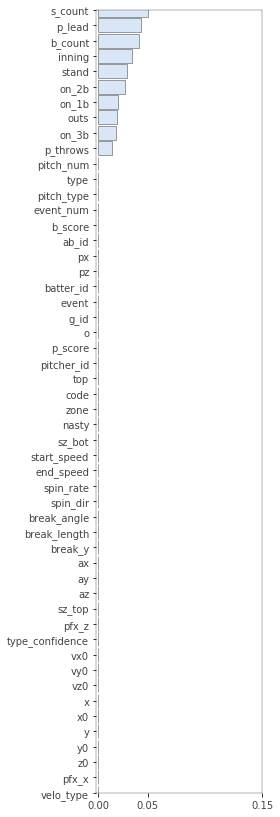

In [111]:
imp = importances(pipe_rf, X_train, y_train)
viz = plot_importances(imp)
viz.view()

In [92]:
# RandomForest Cross Validation
cross_val_score(estimator=pipe_rf, X=X_train, y=y_train, cv=5, scoring='f1',n_jobs=-1)

array([0.71989327, 0.72027124, 0.72094626, 0.72068486, 0.72041892])

__Model Evaluation:__

F1_score is out "north star" metric

In [89]:
# Training score
y_train = np.array(y_train).reshape(-1, 1)
y_train_pred = pipe_rf.predict(X_train)
f1_train = f1_score(y_train, y_train_pred, average="binary")
round(f1_train, 2)

0.75

In [90]:
# Testing score
y_test = np.array(y_test).reshape(-1, 1)
y_test_pred = pipe_rf.predict(X_test)
f1_test = f1_score(y_test, y_test_pred, average="binary")
round(f1_test, 2)

0.72

### Predicting Fastball or Offspeed Summary:

In this scenario our baseline was not a logistic model, but the Houston Astro's cheating scandal which should have a F1_score of close to 1. We were interested in seeing how well a more complex model would perform compared and if data science could have done a comparable job instead of going out and cheating. We got close with F1-score of .76 which is fairly high. Ultimately, we believe we have shown rather than coming up with a cheating scheme with many moving parts, instead you might as well invest all that time, energy, and money into more funding for the analytics department.

## Project Takeaways: 

We learned that some models are not ideal for large datasets even if you have only a few features, looking at you KNN/SVM. One thing we could have done differently would have been to split the data into subsets for each team based on what team the pitcher was on. Then we would do the project over for each team subset. This would probably be more accurate and scalable for implementation for an actual MLB team. Similarly, we got lucky that our data was rather clean and RandomForest gave a pretty good model with minimal parameter tuning because even SearchCV with minimal parameters took overnight to complete. If we had more time we could have tried using distributed computing solutions in attempt to speed up this process or took a much smaller subset for tuning purposes. Either way, we can't complain much about our predictions being right 72% of the time from a simple RandomForest model. 

If only baseball was more open to data science techniques and implementations and wasn't as ingrained in their traditinal ways...